In [153]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pywt
from statsmodels.graphics.tsaplots import plot_acf
from hampel import hampel

# Prep Work

In [2]:
def load_and_concat_data(file_paths, column_names):
    """
    Load and concatenate data from multiple CSV files given by file_paths.

    :param file_paths: List of file paths to the CSV files.
    :param column_names: List of column names for the CSV files.

    :return pd.DataFrame: DataFrame for each feature containing raw data from the years 2023 - 2024.
    """
    df = [pd.read_csv(file_path, header=1, names=column_names) for file_path in file_paths]
    concat_data = pd.concat(df)
    concat_data.reset_index(drop=True, inplace=True)
    concat_data["timestamp"] = pd.to_datetime(concat_data["timestamp"])
    concat_data.set_index("timestamp", inplace=True)
    
    # if na values are present interpolate them based on the timestamp
    if concat_data.isna().sum().sum() > 0:
        concat_data.interpolate(method="time", inplace=True)
    
    return concat_data

### File Paths and Column Names config

In [3]:
file_paths = {
    "de_prices": ["../data/raw/de_prices_2023.csv", "../data/raw/de_prices_2024.csv"],
    "de_load": ["../data/raw/de_load_2023.csv", "../data/raw/de_load_2024.csv"],
    "de_solar_gen": ["../data/raw/de_solar_gen_2023.csv", "../data/raw/de_solar_gen_2024.csv"],
    "de_wind_gen_offshore": ["../data/raw/de_wind_gen_offshore_2023.csv", "../data/raw/de_wind_gen_offshore_2024.csv"],
    "de_wind_gen_onshore": ["../data/raw/de_wind_gen_onshore_2023.csv", "../data/raw/de_wind_gen_onshore_2024.csv"],
    "ch_load": ["../data/raw/ch_load_2023.csv", "../data/raw/ch_load_2024.csv"],
    "dk_load": ["../data/raw/dk_load_2023.csv", "../data/raw/dk_load_2024.csv"],
    "fr_load": ["../data/raw/fr_load_2023.csv", "../data/raw/fr_load_2024.csv"]
}

column_names = {
    "de_prices": ["timestamp", "de_lu_price"],
    "de_load": ["timestamp", "de_load"],
    "de_solar_gen": ["timestamp", "de_solar_gen"],
    "de_wind_gen_offshore": ["timestamp", "de_wind_gen_offshore"],
    "de_wind_gen_onshore": ["timestamp", "de_wind_gen_onshore"],
    "ch_load": ["timestamp", "ch_load"],
    "dk_load": ["timestamp", "dk_load"],
    "fr_load": ["timestamp", "fr_load"]
}

### Populate new dataframes with raw data from years 2023 and 2024

In [4]:
de_prices = load_and_concat_data(file_paths["de_prices"], column_names["de_prices"])
de_load = load_and_concat_data(file_paths["de_load"], column_names["de_load"])
de_solar_gen = load_and_concat_data(file_paths["de_solar_gen"], column_names["de_solar_gen"])
de_wind_gen_offshore = load_and_concat_data(file_paths["de_wind_gen_offshore"], column_names["de_wind_gen_offshore"])
de_wind_gen_onshore = load_and_concat_data(file_paths["de_wind_gen_onshore"], column_names["de_wind_gen_onshore"])
ch_load = load_and_concat_data(file_paths["ch_load"], column_names["ch_load"])
dk_load = load_and_concat_data(file_paths["dk_load"], column_names["dk_load"])
fr_load = load_and_concat_data(file_paths["fr_load"], column_names["fr_load"])

In [5]:
# resample the quarter hourly timeseries to hourly. see readme for affected timeseries
de_load = de_load.resample("h").mean()
de_solar_gen = de_solar_gen.resample("h").mean()
de_wind_gen_offshore = de_wind_gen_offshore.resample("h").mean()
de_wind_gen_onshore = de_wind_gen_onshore.resample("h").mean()

In [83]:
dataframes = [
    de_prices,
    de_load,
    de_solar_gen,
    de_wind_gen_offshore,
    de_wind_gen_onshore,
    ch_load,
    dk_load,
    fr_load
]

combined_df = pd.concat(dataframes, axis=1)
combined_df.to_csv("../data/interim/combined_data.csv")

# Statisical Analysis

In [7]:
# statistical overview
combined_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
de_lu_price,17544.0,87.364521,57.217911,-500.000,62.86750,88.8500,112.50000,2325.830
de_load,17544.0,52660.885957,9124.388618,30902.675,45158.63750,52633.8625,59734.60625,75508.125
de_solar_gen,17544.0,6775.300281,10432.230192,0.850,3.32500,195.5375,10728.57500,46897.525
de_wind_gen_offshore,17544.0,2803.653534,1859.750621,0.000,1126.23125,2611.0375,4326.82500,7633.450
de_wind_gen_onshore,17544.0,13186.427301,10293.850777,46.575,4919.38750,10332.8875,19264.89375,48023.100
ch_load,17544.0,6879.845651,1053.874647,2742.600,6185.05000,6898.4000,7588.72500,10437.100
dk_load,17544.0,4061.867909,718.324942,2371.200,3526.47500,4047.2500,4587.72500,9069.600
fr_load,17544.0,48756.730392,9949.586147,28744.000,41534.50000,47265.0000,54975.50000,82800.000


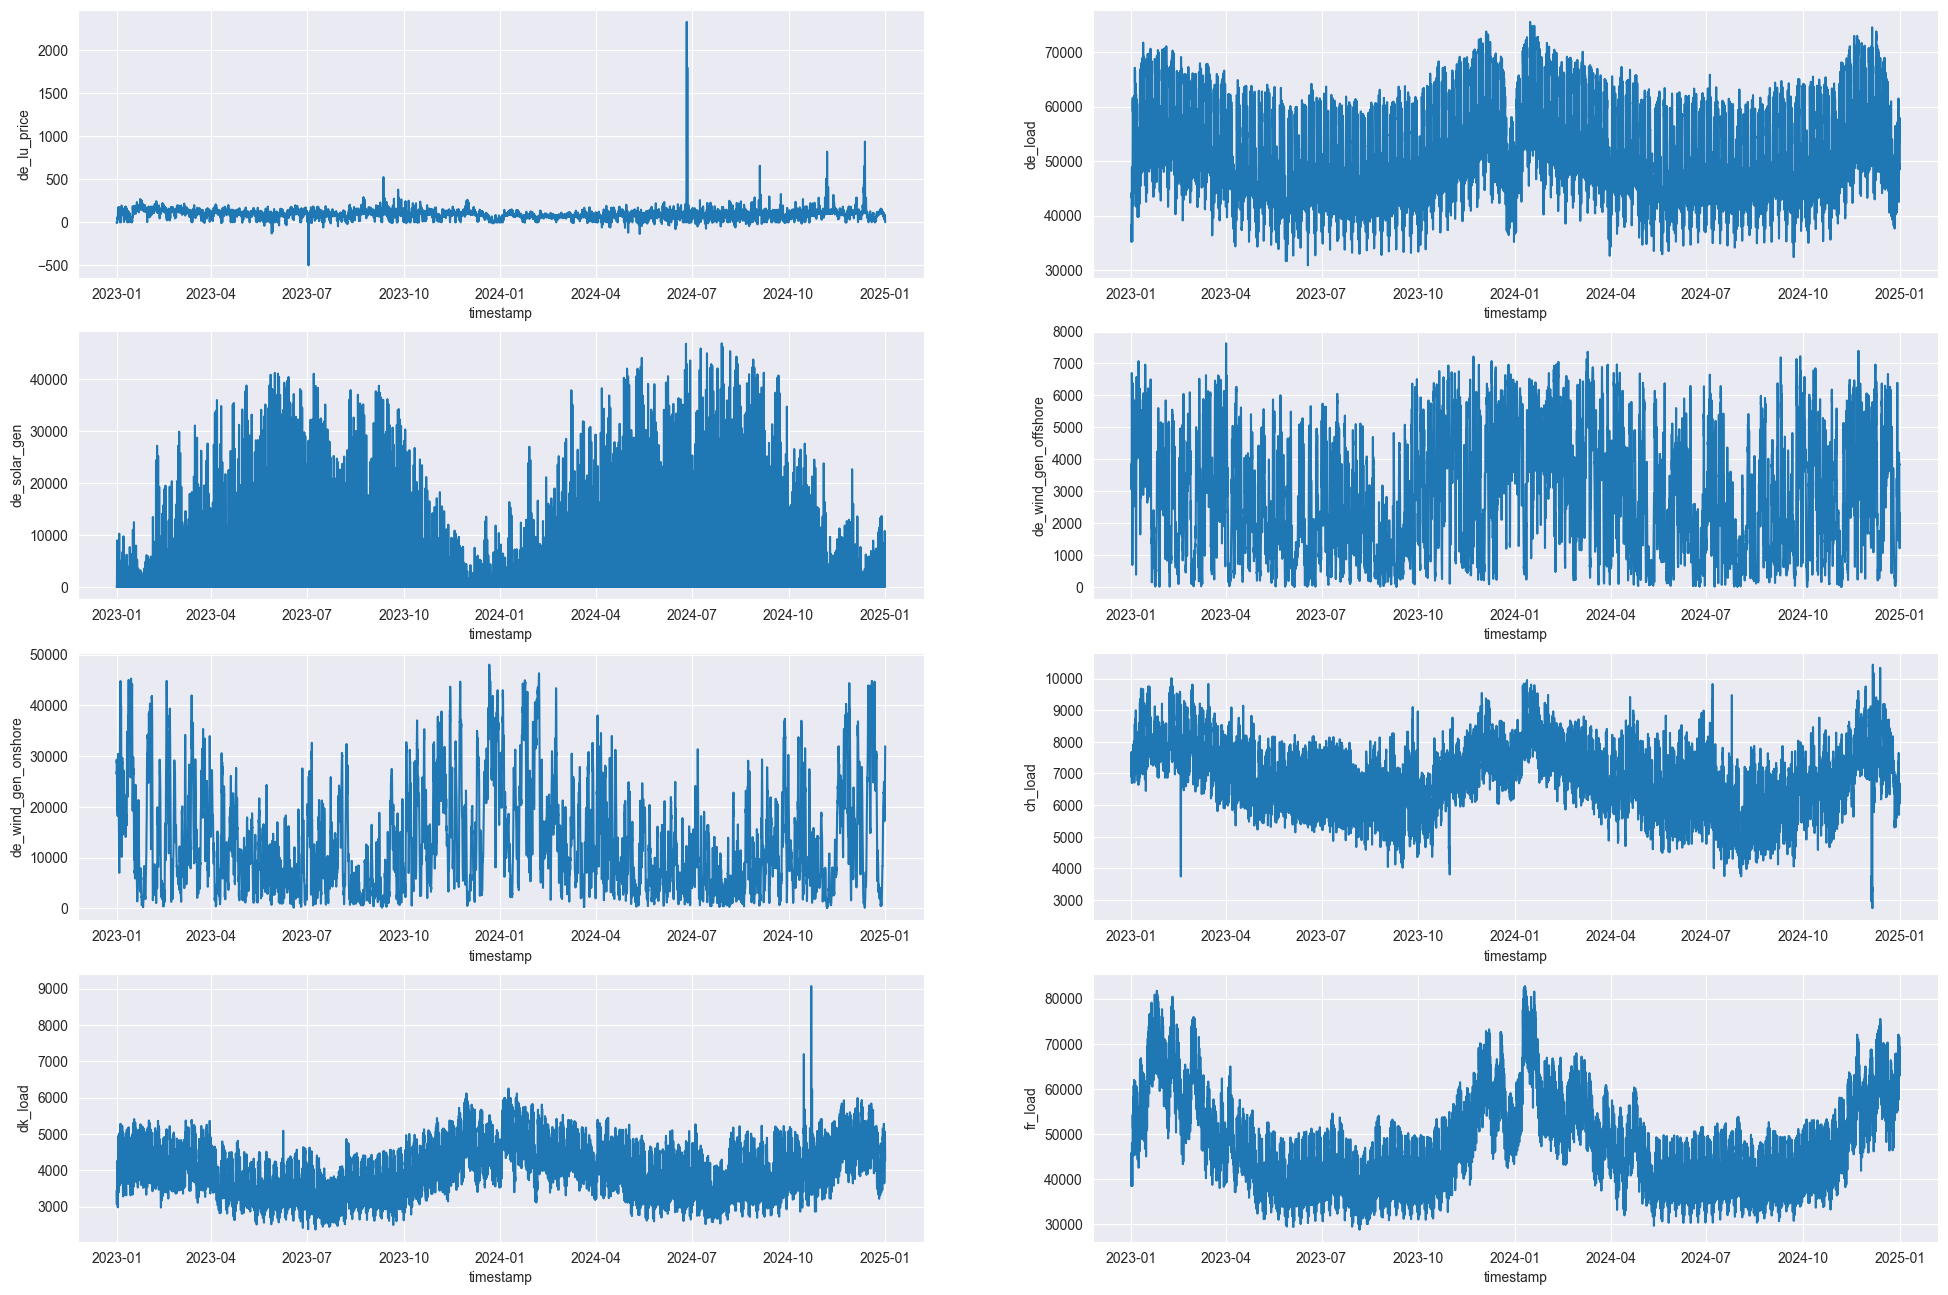

In [26]:
# plot all timeseries for visual inspection
plt.figure(figsize=(24, 16))

for _ in combined_df.columns:
    plt.subplot(4, 2, list(combined_df.columns).index(_)+1)
    sns.lineplot(data=combined_df[_])
    
plt.savefig("../reports/figures/plot_overview.png", dpi=300)

In [ ]:
# get pearson correlation coefficients and plot them
correlation_matrix = combined_df.corr(method="pearson")
correlation_matrix = correlation_matrix.drop(index=["de_lu_price"])
correlation_matrix = correlation_matrix[["de_lu_price"]].sort_values(by="de_lu_price", ascending=False)

cmap = sns.diverging_palette(20, 230, as_cmap=True)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, 
            cmap=cmap,
            annot=True,  
            square=True, 
            cbar=False,
            center=0,
            yticklabels=["DE Load", "FR Load", "DK Load", "CH Load", "DE Wind Gen Offshore", "DE Solar Gen", "DE Wind Gen Onshore"],
            xticklabels=["DE-LU Prices"]).set_title("Correlation coefficients")

plt.savefig("../reports/figures/de_lu_price_correlations.png", dpi=300)

plt.show()

### fft and autocorrelation are not suitable because given timeseries is non-stationary

### are they, are they not?

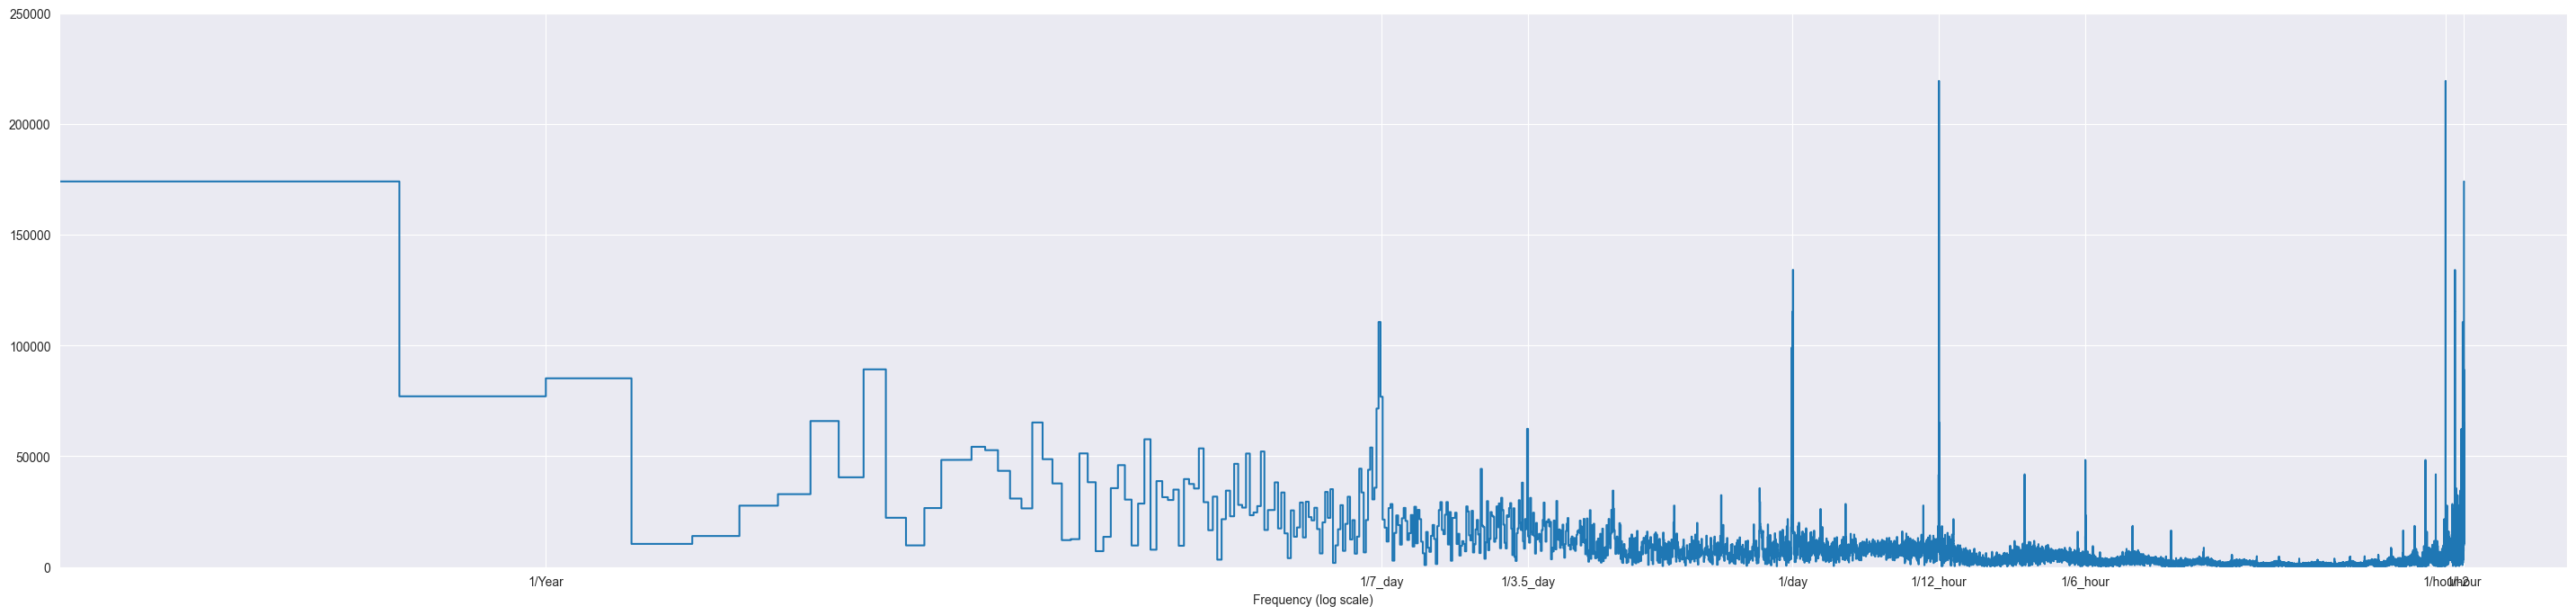

In [139]:
# to check which frequencies are present in the timeseries data fft and wavelet transform are used
fft = tf.signal.fft(combined_df["de_lu_price"])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(combined_df["de_lu_price"])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

plt.figure(figsize=(36, 8))
f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 250000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524/7, 365.2524/3.5, 365.2524, 365.2524*2, 365.2524*24/6, 365.2524*22, 365.2524*24], labels=['1/Year', '1/7_day', '1/3.5_day', '1/day', '1/12_hour', '1/6_hour', '1/hour-2', '1/hour'])
_ = plt.xlabel('Frequency (log scale)')

<Figure size 2400x800 with 0 Axes>

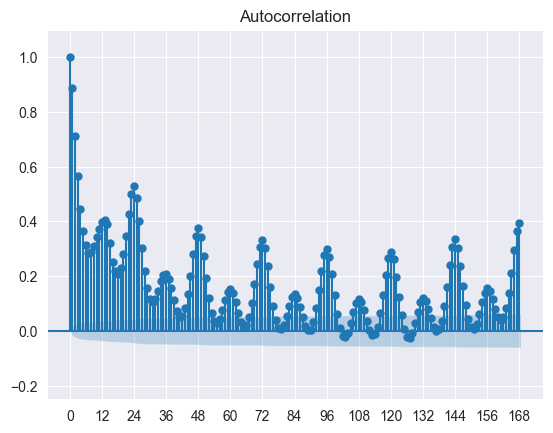

In [123]:
# to further validate time frequencies autocorrelation is measured
plt.figure(figsize=(24, 8))
plot_acf(combined_df["de_lu_price"], lags=7*24)
plt.ylim(-0.25, 1.1)
plt.xticks(np.arange(0, 7*24+1, 12))
plt.show()

### wavelet transform is utilized for non-stationary timeseries data to decompose the signal into different frequencies


In [136]:
# wavelet transform
coefficients = pywt.dwt(combined_df["de_lu_price"], "db5")
coefficients
#plt.imshow(np.abs(coefficients), extent=[0,1,1,100], cmap='PRGn', aspect='auto',
           #vmax=abs(coefficients).max(), vmin=-abs(coefficients).max())

(array([-6.48316623, -7.42557957, -1.94831494, ..., 78.9809279 ,
        21.79189349,  2.4485948 ]),
 array([ 0.76820791, -1.16189842,  1.90909175, ..., -3.19762269,
         7.29934142, -2.56950988]))

# Feature Engineering

In [85]:
# convert timestamp to seconds accoring to [2] in /refs/README.md
timestamp_s = combined_df.index.map(pd.Timestamp.timestamp)

In [141]:
# create lagged prices according to fft analysis
# 7 day, 1 day, 12 hour and 1 hour lags are introduced
combined_df["de_lu_price_7_day_lag"] = combined_df["de_lu_price"].shift(-7*24, fill_value=0)
combined_df["de_lu_price_1_day_lag"] = combined_df["de_lu_price"].shift(-24, fill_value=0)
combined_df["de_lu_price_12_hour_lag"] = combined_df["de_lu_price"].shift(-12, fill_value=0)
combined_df["de_lu_price_1_hour_lag"] = combined_df["de_lu_price"].shift(-1, fill_value=0)
combined_df.tail()

,de_lu_price,de_load,de_solar_gen,de_wind_gen_offshore,de_wind_gen_onshore,ch_load,dk_load,fr_load,de_lu_price_7_day_lag,de_lu_price_1_day_lag,de_lu_price_12_hour_lag,de_lu_price_1_hour_lag
timestamp,,,,,,,,,,,,
2024-12-31 18:00:00+00:00,4.230768,10.903827,2.525729,7.394063,10.282717,8.806289,8.453124,11.130508,0.0,0.0,0.0,3.598955
2024-12-31 19:00:00+00:00,3.598955,10.843303,2.060514,7.262734,10.339655,8.765396,8.408248,11.086242,0.0,0.0,0.0,2.815409
2024-12-31 20:00:00+00:00,2.815409,10.806445,2.041220,7.096680,10.369632,8.734109,8.374546,11.049095,0.0,0.0,0.0,2.308567
2024-12-31 21:00:00+00:00,2.308567,10.789154,2.088773,7.334395,10.337455,8.740289,8.363016,11.066388,0.0,0.0,0.0,0.418710
2024-12-31 22:00:00+00:00,0.418710,10.804380,2.004853,7.744776,10.372064,8.752234,8.359346,11.076032,0.0,0.0,0.0,0.000000


C:\Users\valen\AppData\Local\Temp\ipykernel_1528\3019842461.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(outlier_indices, combined_df["de_lu_price"][outlier_indices], 'ro', label="Outliers")


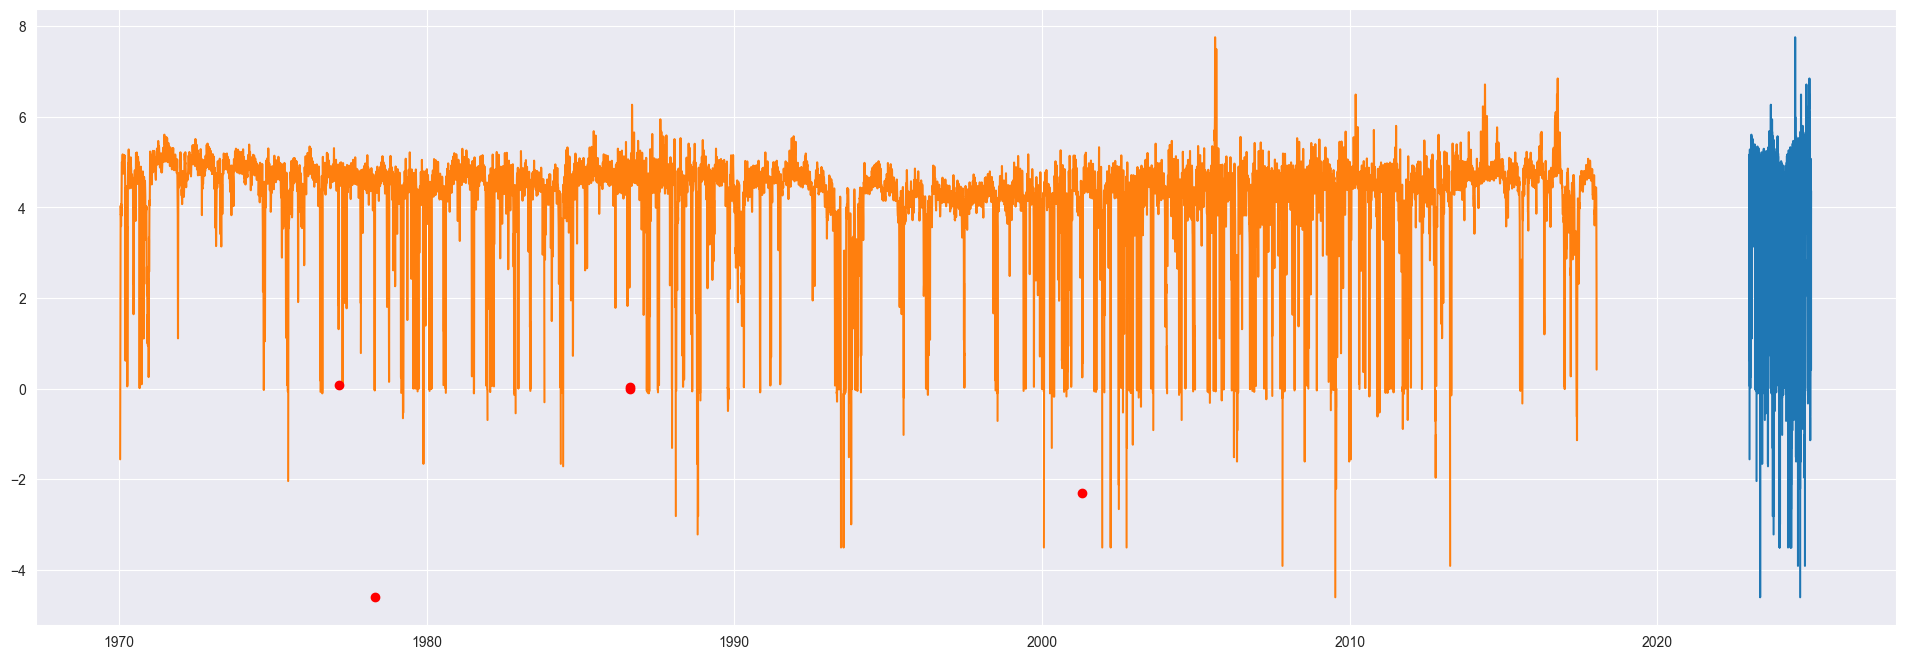

In [161]:
# detect and remove outliers refer to [3] /references/refs.md
result = hampel(combined_df["de_lu_price"], window_size=7*24, n_sigma=23.5)

filtered_data = result.filtered_data
outlier_indices = result.outlier_indices
medians = result.medians
mad_values = result.median_absolute_deviations
thresholds = result.thresholds



In [ ]:
# plot the data with outlier filter
plt.figure(figsize=(24, 8))
plt.plot(combined_df["de_lu_price"], label="Original")
plt.plot(filtered_data, label="Filtered")
plt.plot(outlier_indices, combined_df["de_lu_price"][outlier_indices], 'ro', label="Outliers")
plt.show()

In [ ]:
# normalize features


In [ ]:
# plot normalized feature distributions
